In [1]:
import sys
import os
import time

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

from util import SaturatedGrowthModel
from copy import deepcopy

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Image
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars

from pysindy.utils import lorenz, lorenz_control, enzyme
import pysindy as ps

# bad code but allows us to ignore warnings
import warnings
# from scipy.integrate.odepack import ODEintWarning
from scipy.integrate import ODEintWarning
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=ODEintWarning)

from scipy.integrate import trapezoid
from scipy.interpolate import interp1d

# Seed the random number generators for reproducibility
np.random.seed(100)

# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

from util import create_datasets, export_coefficients, export_mse_mae, export_thereshold
from plot import plot_models
from pysindy.feature_library import CustomLibrary
from plot import plot_pareto

# Training Data [0,10] noise = 0.05

In [2]:
output_path = "Compare_with_SciANN"
if not os.path.isdir(output_path):
    os.makedirs(output_path)
    
tag = "FD"

(100, 1) (100,) (500, 1) (500,)
0.797979797979798 0.13131313131313133
(u)' = 1.055 u + -0.900 u^2
Coefficients exported to Compare_with_SciANN\PySINDy_SG_0.05_FD_100_500_[0, 10]\coefs_FD_0.05_100_[0, 10].csv
Threshold exported to Compare_with_SciANN\PySINDy_SG_0.05_FD_100_500_[0, 10]\threshold_FD_0.05_100_[0, 10].csv


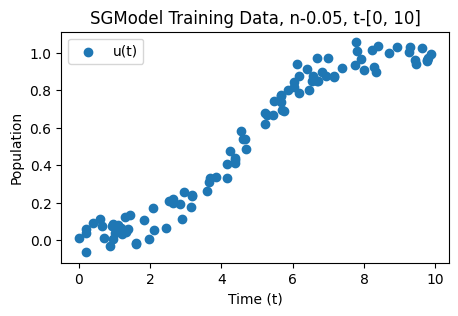

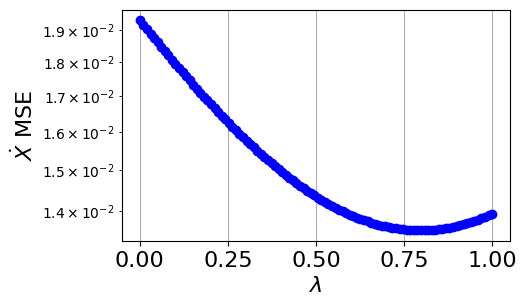

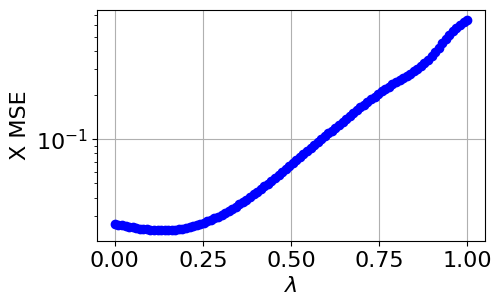

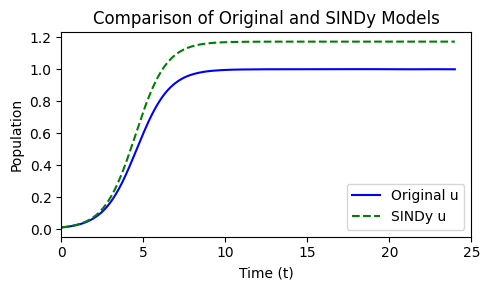

In [3]:
# fixed parameters  
C = 1
tend = 24
numx = 100	
nTest = 500
initial_conditions = [0.01]
noise_level = 0.05
show_figure = True
sparse = True
time_limit = [0, 10]
seed = 0

output_folder = os.path.join(output_path, f"PySINDy_SG_{noise_level}_{tag}_{numx}_{nTest}_{time_limit}")
if not os.path.isdir(output_folder):
        os.mkdir(output_folder)
plot_save_file = "training_data_plot.png"
plot_save_path = os.path.join(output_folder, plot_save_file)

x_train, t_train, x_test, t_test = create_datasets(model=SaturatedGrowthModel, 
                                                       tend=tend, 
                                                       numx=numx,
                                                       nTest=nTest,
                                                       initial_conditions=initial_conditions, 
                                                       params=C, 
                                                       training_time_limit=time_limit, 
                                                       noise_level=noise_level, 
                                                       show_figure=show_figure,
                                                       save_path=plot_save_path,
                                                       sparse=sparse,
                                                       seed=seed)
print(x_train.shape, t_train.shape, x_test.shape, t_test.shape)

# set feature library
max_threshold = 1
num_threshold = 100

feature_names = ["u"]
feature_library = ps.PolynomialLibrary(degree=2, include_bias=False)

# Add constraining optimization
n_targets = 1
n_features = 2
constraint_rhs = np.asarray([-1])
constraint_lhs = np.zeros((1, n_targets*n_features))
constraint_lhs[0, 1] = 1

coefs = []
threshold_scan = np.linspace(0, max_threshold, num_threshold)

for threshold in threshold_scan:
    opt = ps.ConstrainedSR3(constraint_rhs=constraint_rhs, 
                            constraint_lhs=constraint_lhs,
                            threshold=threshold,
                            thresholder='l1', trimming_fraction=0.33)
    model = ps.SINDy(feature_names=feature_names,
                     optimizer=opt,
                     feature_library=feature_library,
                     differentiation_method=ps.FiniteDifference())
    model.fit(x_train, t=t_train, quiet=True)
    coefs.append(model.coefficients())

lambda_mse, lambda_mse_sim = plot_pareto(coefs, opt, model, threshold_scan, x_test, t_test)

print(lambda_mse, lambda_mse_sim)   

## run the model with optimal value
opt = ps.ConstrainedSR3(constraint_rhs=constraint_rhs,
                              constraint_lhs=constraint_lhs,
                              threshold=0.1, thresholder='l1', trimming_fraction=0.33)
model = ps.SINDy(feature_names=feature_names, optimizer=opt,
                    feature_library=feature_library, differentiation_method=ps.FiniteDifference())
model.fit(x_train, t=t_train, ensemble=False, quiet=True)
model.print()
plot_models(tend, initial_conditions, C, SaturatedGrowthModel, model)
plt.tight_layout()

# save matrics
metrics_file_name = f"metrics_{tag}_{noise_level}_{numx}_{time_limit}.csv"
metrics_save_path = os.path.join(output_folder, metrics_file_name)
export_mse_mae(model, x_test, t_test, metrics_save_path)

# save coefficients
coefs_file_name = f"coefs_{tag}_{noise_level}_{numx}_{time_limit}.csv"
coefs_save_path = os.path.join(output_folder, coefs_file_name)
export_coefficients(model.coefficients(), coefs_save_path)

# save threshold
threshold_file_name = f"threshold_{tag}_{noise_level}_{numx}_{time_limit}.csv"
threshold_save_path = os.path.join(output_folder, threshold_file_name)
export_thereshold(opt, threshold_save_path)

Training Data [0, 24] noise = 0.05

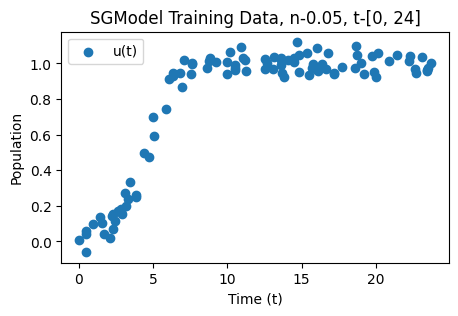

(100, 1) (100,) (500, 1) (500,)
0.4545454545454546 0.11111111111111112
(u)' = 0.995 u + -0.900 u^2
Coefficients exported to Compare_with_SciANN\PySINDy_SG_0.05_FD_100_500_[0, 24]\coefs_FD_0.05_100_[0, 24].csv
Threshold exported to Compare_with_SciANN\PySINDy_SG_0.05_FD_100_500_[0, 24]\threshold_FD_0.05_100_[0, 24].csv


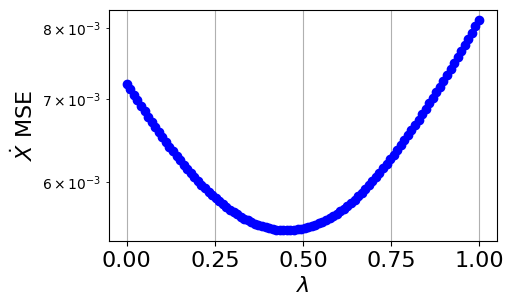

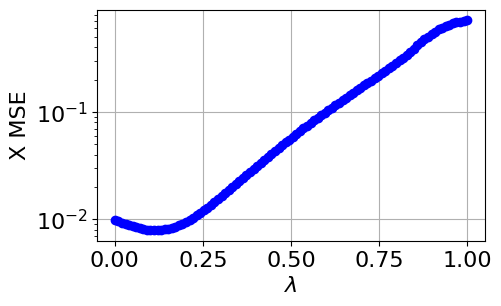

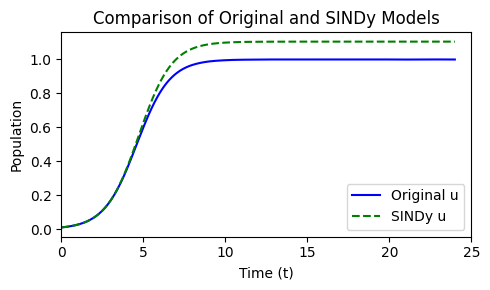

In [4]:
# fixed parameters  
C = 1
tend = 24
numx = 100	
nTest = 500
initial_conditions = [0.01]
noise_level = 0.05
show_figure = True
sparse = True
time_limit = [0, 24]
seed = 0

output_folder = os.path.join(output_path, f"PySINDy_SG_{noise_level}_{tag}_{numx}_{nTest}_{time_limit}")
if not os.path.isdir(output_folder):
        os.mkdir(output_folder)
plot_save_file = "training_data_plot.png"
plot_save_path = os.path.join(output_folder, plot_save_file)

x_train, t_train, x_test, t_test = create_datasets(model=SaturatedGrowthModel, 
                                                       tend=tend, 
                                                       numx=numx,
                                                       nTest=nTest,
                                                       initial_conditions=initial_conditions, 
                                                       params=C, 
                                                       training_time_limit=time_limit, 
                                                       noise_level=noise_level, 
                                                       show_figure=show_figure,
                                                       sparse=sparse,
                                                       seed=seed)
print(x_train.shape, t_train.shape, x_test.shape, t_test.shape)

# set feature library
max_threshold = 1
num_threshold = 100

feature_names = ["u"]
feature_library = ps.PolynomialLibrary(degree=2, include_bias=False)

# Add constraining optimization
n_targets = 1
n_features = 2
constraint_rhs = np.asarray([-1])
constraint_lhs = np.zeros((1, n_targets*n_features))
constraint_lhs[0, 1] = 1

coefs = []
threshold_scan = np.linspace(0, max_threshold, num_threshold)

for threshold in threshold_scan:
    opt = ps.ConstrainedSR3(constraint_rhs=constraint_rhs, 
                            constraint_lhs=constraint_lhs,
                            threshold=threshold,
                            thresholder='l1', trimming_fraction=0.33)
    model = ps.SINDy(feature_names=feature_names,
                     optimizer=opt,
                     feature_library=feature_library,
                     differentiation_method=ps.FiniteDifference())
    model.fit(x_train, t=t_train, quiet=True)
    coefs.append(model.coefficients())

lambda_mse, lambda_mse_sim = plot_pareto(coefs, opt, model, threshold_scan, x_test, t_test)

print(lambda_mse, lambda_mse_sim)   

## run the model with optimal value
opt = ps.ConstrainedSR3(constraint_rhs=constraint_rhs,
                              constraint_lhs=constraint_lhs,
                              threshold=0.1, thresholder='l1', trimming_fraction=0.33)
model = ps.SINDy(feature_names=feature_names, optimizer=opt,
                    feature_library=feature_library, differentiation_method=ps.FiniteDifference())
model.fit(x_train, t=t_train, ensemble=False, quiet=True)
model.print()
plot_models(tend, initial_conditions, C, SaturatedGrowthModel, model)
plt.tight_layout()

# save matrics
metrics_file_name = f"metrics_{tag}_{noise_level}_{numx}_{time_limit}.csv"
metrics_save_path = os.path.join(output_folder, metrics_file_name)
export_mse_mae(model, x_test, t_test, metrics_save_path)

# save coefficients
coefs_file_name = f"coefs_{tag}_{noise_level}_{numx}_{time_limit}.csv"
coefs_save_path = os.path.join(output_folder, coefs_file_name)
export_coefficients(model.coefficients(), coefs_save_path)


# save threshold
threshold_file_name = f"threshold_{tag}_{noise_level}_{numx}_{time_limit}.csv"
threshold_save_path = os.path.join(output_folder, threshold_file_name)
export_thereshold(opt, threshold_save_path)

Training Data [10, 24] noise = 0.05

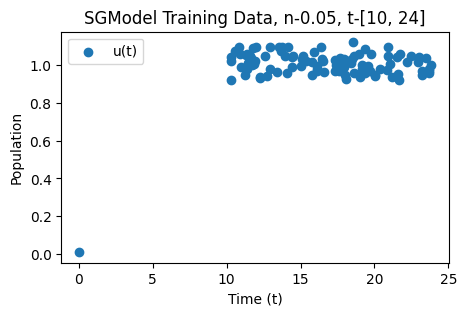

(100, 1) (100,) (500, 1) (500,)
0.4141414141414142 0.11111111111111112
(u)' = 0.998 u + -0.900 u^2
Coefficients exported to Compare_with_SciANN\PySINDy_SG_0.05_FD_100_500_[10, 24]\coefs_FD_0.05_100_[10, 24].csv
Threshold exported to Compare_with_SciANN\PySINDy_SG_0.05_FD_100_500_[10, 24]\threshold_FD_0.05_100_[10, 24].csv


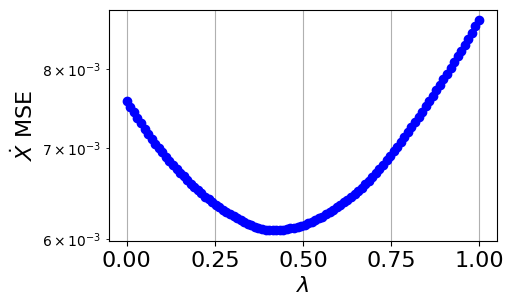

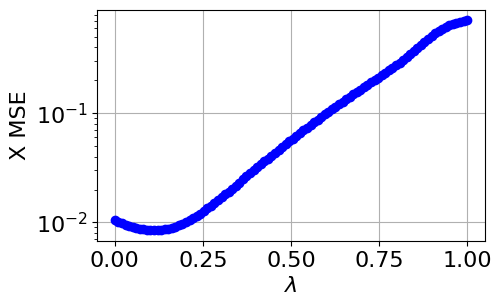

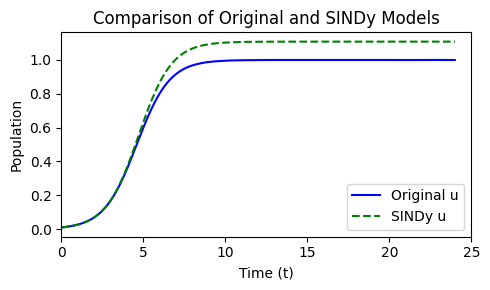

In [5]:
# fixed parameters  
C = 1
tend = 24
numx = 100	
nTest = 500
initial_conditions = [0.01]
noise_level = 0.05
show_figure = True
sparse = True
time_limit = [10, 24]
seed = 0

output_folder = os.path.join(output_path, f"PySINDy_SG_{noise_level}_{tag}_{numx}_{nTest}_{time_limit}")
if not os.path.isdir(output_folder):
        os.mkdir(output_folder)
plot_save_file = "training_data_plot.png"
plot_save_path = os.path.join(output_folder, plot_save_file)

x_train, t_train, x_test, t_test = create_datasets(model=SaturatedGrowthModel, 
                                                       tend=tend, 
                                                       numx=numx,
                                                       nTest=nTest,
                                                       initial_conditions=initial_conditions, 
                                                       params=C, 
                                                       training_time_limit=time_limit, 
                                                       noise_level=noise_level, 
                                                       show_figure=show_figure,
                                                       sparse=sparse,
                                                       seed=seed)
print(x_train.shape, t_train.shape, x_test.shape, t_test.shape)

# set feature library
max_threshold = 1
num_threshold = 100

feature_names = ["u"]
feature_library = ps.PolynomialLibrary(degree=2, include_bias=False)

# Add constraining optimization
n_targets = 1
n_features = 2
constraint_rhs = np.asarray([-1])
constraint_lhs = np.zeros((1, n_targets*n_features))
constraint_lhs[0, 1] = 1

coefs = []
threshold_scan = np.linspace(0, max_threshold, num_threshold)

for threshold in threshold_scan:
    opt = ps.ConstrainedSR3(constraint_rhs=constraint_rhs, 
                            constraint_lhs=constraint_lhs,
                            threshold=threshold,
                            thresholder='l1', trimming_fraction=0.33)
    model = ps.SINDy(feature_names=feature_names,
                     optimizer=opt,
                     feature_library=feature_library,
                     differentiation_method=ps.FiniteDifference())
    model.fit(x_train, t=t_train, quiet=True)
    coefs.append(model.coefficients())

lambda_mse, lambda_mse_sim = plot_pareto(coefs, opt, model, threshold_scan, x_test, t_test)

print(lambda_mse, lambda_mse_sim)   

## run the model with optimal value
opt = ps.ConstrainedSR3(constraint_rhs=constraint_rhs,
                              constraint_lhs=constraint_lhs,
                              threshold=0.1, thresholder='l1', trimming_fraction=0.33)
model = ps.SINDy(feature_names=feature_names, optimizer=opt,
                    feature_library=feature_library, differentiation_method=ps.FiniteDifference())
model.fit(x_train, t=t_train, ensemble=False, quiet=True)
model.print()
plot_models(tend, initial_conditions, C, SaturatedGrowthModel, model)
plt.tight_layout()

# save matrics
metrics_file_name = f"metrics_{tag}_{noise_level}_{numx}_{time_limit}.csv"
metrics_save_path = os.path.join(output_folder, metrics_file_name)
export_mse_mae(model, x_test, t_test, metrics_save_path)

# save coefficients
coefs_file_name = f"coefs_{tag}_{noise_level}_{numx}_{time_limit}.csv"
coefs_save_path = os.path.join(output_folder, coefs_file_name)
export_coefficients(model.coefficients(), coefs_save_path)


# save threshold
threshold_file_name = f"threshold_{tag}_{noise_level}_{numx}_{time_limit}.csv"
threshold_save_path = os.path.join(output_folder, threshold_file_name)
export_thereshold(opt, threshold_save_path)

Training Data [0, 10] with noise = 0.005

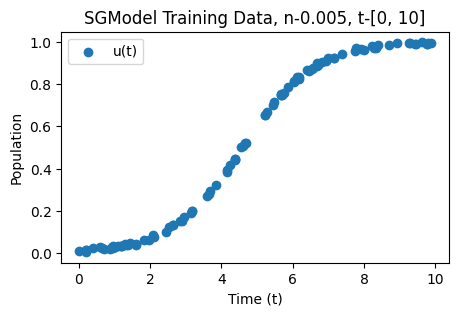

(100, 1) (100,) (500, 1) (500,)
0.05050505050505051 0.010101010101010102
(u)' = 0.978 u + -0.970 u^2
Coefficients exported to Compare_with_SciANN\PySINDy_SG_0.005_FD_100_500_[0, 10]\coefs_FD_0.005_100_[0, 10].csv
Threshold exported to Compare_with_SciANN\PySINDy_SG_0.005_FD_100_500_[0, 10]\threshold_FD_0.005_100_[0, 10].csv


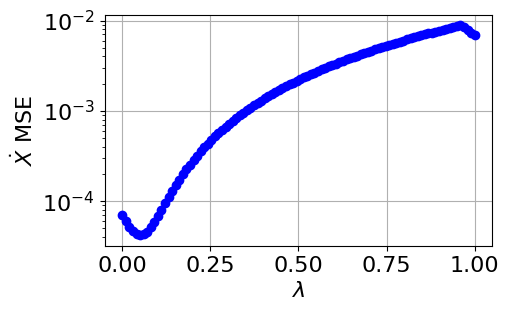

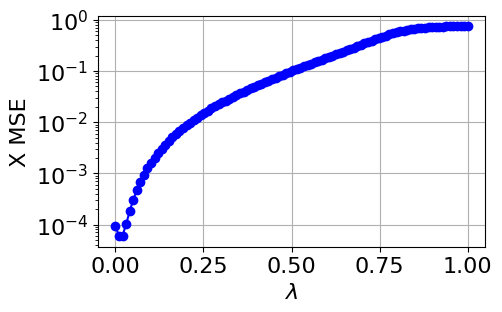

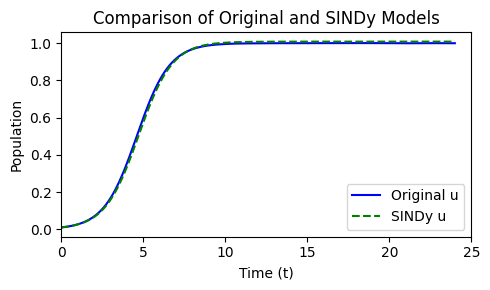

In [6]:
# fixed parameters  
C = 1
tend = 24
numx = 100	
nTest = 500
initial_conditions = [0.01]
noise_level = 0.005
show_figure = True
sparse = True
time_limit = [0, 10]
seed = 0

output_folder = os.path.join(output_path, f"PySINDy_SG_{noise_level}_{tag}_{numx}_{nTest}_{time_limit}")
if not os.path.isdir(output_folder):
        os.mkdir(output_folder)
plot_save_file = "training_data_plot.png"
plot_save_path = os.path.join(output_folder, plot_save_file)

x_train, t_train, x_test, t_test = create_datasets(model=SaturatedGrowthModel, 
                                                       tend=tend, 
                                                       numx=numx,
                                                       nTest=nTest,
                                                       initial_conditions=initial_conditions, 
                                                       params=C, 
                                                       training_time_limit=time_limit, 
                                                       noise_level=noise_level, 
                                                       show_figure=show_figure,
                                                       sparse=sparse,
                                                       seed=seed)
print(x_train.shape, t_train.shape, x_test.shape, t_test.shape)

# set feature library
max_threshold = 1
num_threshold = 100

feature_names = ["u"]
feature_library = ps.PolynomialLibrary(degree=2, include_bias=False)

# Add constraining optimization
n_targets = 1
n_features = 2
constraint_rhs = np.asarray([-1])
constraint_lhs = np.zeros((1, n_targets*n_features))
constraint_lhs[0, 1] = 1

coefs = []
threshold_scan = np.linspace(0, max_threshold, num_threshold)

for threshold in threshold_scan:
    opt = ps.ConstrainedSR3(constraint_rhs=constraint_rhs, 
                            constraint_lhs=constraint_lhs,
                            threshold=threshold,
                            thresholder='l1', trimming_fraction=0.33)
    model = ps.SINDy(feature_names=feature_names,
                     optimizer=opt,
                     feature_library=feature_library,
                     differentiation_method=ps.FiniteDifference())
    model.fit(x_train, t=t_train, quiet=True)
    coefs.append(model.coefficients())

lambda_mse, lambda_mse_sim = plot_pareto(coefs, opt, model, threshold_scan, x_test, t_test)

print(lambda_mse, lambda_mse_sim)   

## run the model with optimal value
opt = ps.ConstrainedSR3(constraint_rhs=constraint_rhs,
                              constraint_lhs=constraint_lhs,
                              threshold=0.03, thresholder='l1', trimming_fraction=0.33)
model = ps.SINDy(feature_names=feature_names, optimizer=opt,
                    feature_library=feature_library, differentiation_method=ps.FiniteDifference())
model.fit(x_train, t=t_train, ensemble=False, quiet=True)
model.print()
plot_models(tend, initial_conditions, C, SaturatedGrowthModel, model)
plt.tight_layout()

# save matrics
metrics_file_name = f"metrics_{tag}_{noise_level}_{numx}_{time_limit}.csv"
metrics_save_path = os.path.join(output_folder, metrics_file_name)
export_mse_mae(model, x_test, t_test, metrics_save_path)

# save coefficients
coefs_file_name = f"coefs_{tag}_{noise_level}_{numx}_{time_limit}.csv"
coefs_save_path = os.path.join(output_folder, coefs_file_name)
export_coefficients(model.coefficients(), coefs_save_path)


# save threshold
threshold_file_name = f"threshold_{tag}_{noise_level}_{numx}_{time_limit}.csv"
threshold_save_path = os.path.join(output_folder, threshold_file_name)
export_thereshold(opt, threshold_save_path)

Training Data [0, 24] with noise = 0.005

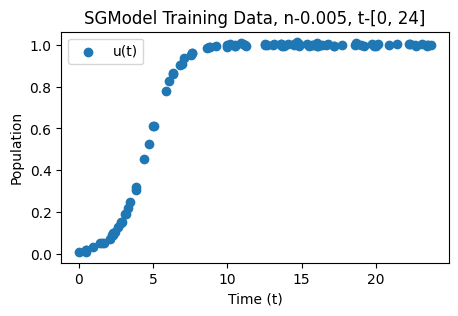

(100, 1) (100,) (500, 1) (500,)
0.030303030303030304 0.010101010101010102
(u)' = 0.987 u + -0.980 u^2
Coefficients exported to Compare_with_SciANN\PySINDy_SG_0.005_FD_100_500_[0, 24]\coefs_FD_0.005_100_[0, 24].csv
Threshold exported to Compare_with_SciANN\PySINDy_SG_0.005_FD_100_500_[0, 24]\threshold_FD_0.005_100_[0, 24].csv


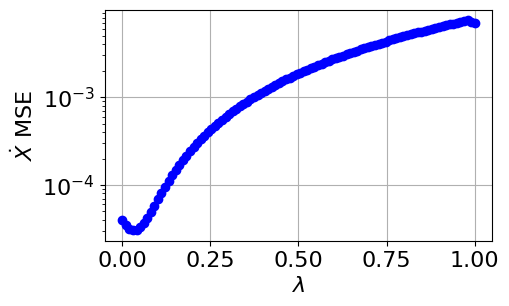

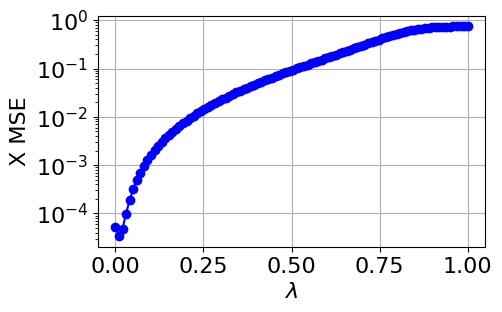

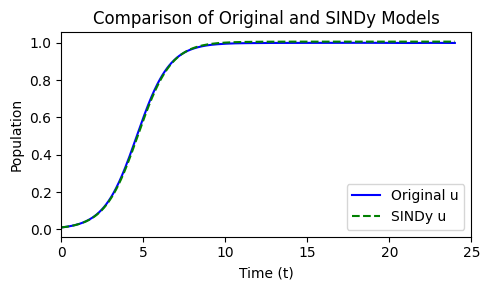

In [7]:
# fixed parameters  
C = 1
tend = 24
numx = 100	
nTest = 500
initial_conditions = [0.01]
noise_level = 0.005
show_figure = True
sparse = True
time_limit = [0, 24]
seed = 0

output_folder = os.path.join(output_path, f"PySINDy_SG_{noise_level}_{tag}_{numx}_{nTest}_{time_limit}")
if not os.path.isdir(output_folder):
        os.mkdir(output_folder)
plot_save_file = "training_data_plot.png"
plot_save_path = os.path.join(output_folder, plot_save_file)

x_train, t_train, x_test, t_test = create_datasets(model=SaturatedGrowthModel, 
                                                       tend=tend, 
                                                       numx=numx,
                                                       nTest=nTest,
                                                       initial_conditions=initial_conditions, 
                                                       params=C, 
                                                       training_time_limit=time_limit, 
                                                       noise_level=noise_level, 
                                                       show_figure=show_figure,
                                                       sparse=sparse,
                                                       seed=seed)
print(x_train.shape, t_train.shape, x_test.shape, t_test.shape)

# set feature library
max_threshold = 1
num_threshold = 100

feature_names = ["u"]
feature_library = ps.PolynomialLibrary(degree=2, include_bias=False)

# Add constraining optimization
n_targets = 1
n_features = 2
constraint_rhs = np.asarray([-1])
constraint_lhs = np.zeros((1, n_targets*n_features))
constraint_lhs[0, 1] = 1

coefs = []
threshold_scan = np.linspace(0, max_threshold, num_threshold)

for threshold in threshold_scan:
    opt = ps.ConstrainedSR3(constraint_rhs=constraint_rhs, 
                            constraint_lhs=constraint_lhs,
                            threshold=threshold,
                            thresholder='l1', trimming_fraction=0.33)
    model = ps.SINDy(feature_names=feature_names,
                     optimizer=opt,
                     feature_library=feature_library,
                     differentiation_method=ps.FiniteDifference())
    model.fit(x_train, t=t_train, quiet=True)
    coefs.append(model.coefficients())

lambda_mse, lambda_mse_sim = plot_pareto(coefs, opt, model, threshold_scan, x_test, t_test)

print(lambda_mse, lambda_mse_sim)   

## run the model with optimal value
opt = ps.ConstrainedSR3(constraint_rhs=constraint_rhs,
                              constraint_lhs=constraint_lhs,
                              threshold=0.02, thresholder='l1', trimming_fraction=0.33)
model = ps.SINDy(feature_names=feature_names, optimizer=opt,
                    feature_library=feature_library, differentiation_method=ps.FiniteDifference())
model.fit(x_train, t=t_train, ensemble=False, quiet=True)
model.print()
plot_models(tend, initial_conditions, C, SaturatedGrowthModel, model)
plt.tight_layout()

# save matrics
metrics_file_name = f"metrics_{tag}_{noise_level}_{numx}_{time_limit}.csv"
metrics_save_path = os.path.join(output_folder, metrics_file_name)
export_mse_mae(model, x_test, t_test, metrics_save_path)

# save coefficients
coefs_file_name = f"coefs_{tag}_{noise_level}_{numx}_{time_limit}.csv"
coefs_save_path = os.path.join(output_folder, coefs_file_name)
export_coefficients(model.coefficients(), coefs_save_path)


# save threshold
threshold_file_name = f"threshold_{tag}_{noise_level}_{numx}_{time_limit}.csv"
threshold_save_path = os.path.join(output_folder, threshold_file_name)
export_thereshold(opt, threshold_save_path)

Training Data [10, 24] with noise = 0.005

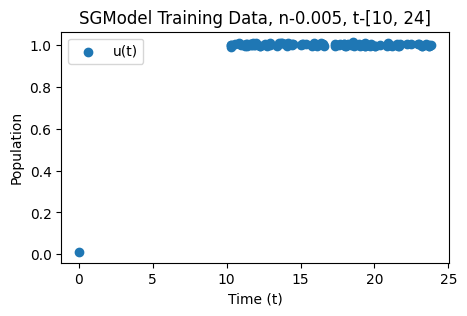

(100, 1) (100,) (500, 1) (500,)
0.0 0.0
(u)' = 0.996 u + -1.000 u^2
Coefficients exported to Compare_with_SciANN\PySINDy_SG_0.005_FD_100_500_[10, 24]\coefs_FD_0.005_100_[10, 24].csv
Threshold exported to Compare_with_SciANN\PySINDy_SG_0.005_FD_100_500_[10, 24]\threshold_FD_0.005_100_[10, 24].csv


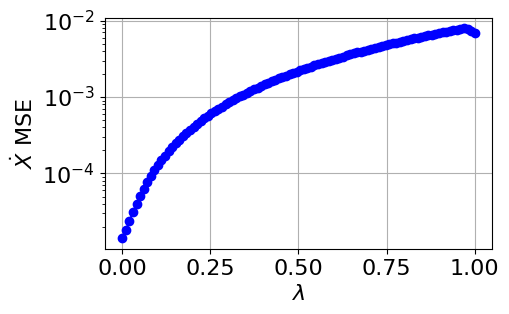

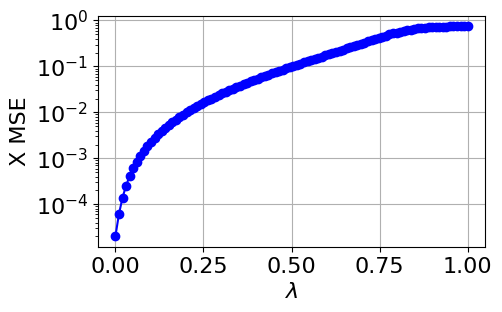

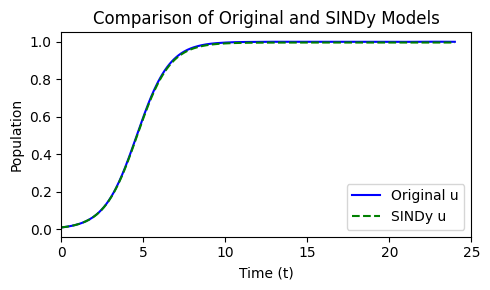

In [8]:
# fixed parameters  
C = 1
tend = 24
numx = 100	
nTest = 500
initial_conditions = [0.01]
noise_level = 0.005
show_figure = True
sparse = True
time_limit = [10, 24]
seed = 0

output_folder = os.path.join(output_path, f"PySINDy_SG_{noise_level}_{tag}_{numx}_{nTest}_{time_limit}")
if not os.path.isdir(output_folder):
        os.mkdir(output_folder)
plot_save_file = "training_data_plot.png"
plot_save_path = os.path.join(output_folder, plot_save_file)

x_train, t_train, x_test, t_test = create_datasets(model=SaturatedGrowthModel, 
                                                       tend=tend, 
                                                       numx=numx,
                                                       nTest=nTest,
                                                       initial_conditions=initial_conditions, 
                                                       params=C, 
                                                       training_time_limit=time_limit, 
                                                       noise_level=noise_level, 
                                                       show_figure=show_figure,
                                                       sparse=sparse,
                                                       seed=seed)
print(x_train.shape, t_train.shape, x_test.shape, t_test.shape)

# set feature library
max_threshold = 1
num_threshold = 100

feature_names = ["u"]
feature_library = ps.PolynomialLibrary(degree=2, include_bias=False)

# Add constraining optimization
n_targets = 1
n_features = 2
constraint_rhs = np.asarray([-1])
constraint_lhs = np.zeros((1, n_targets*n_features))
constraint_lhs[0, 1] = 1

coefs = []
threshold_scan = np.linspace(0, max_threshold, num_threshold)

for threshold in threshold_scan:
    opt = ps.ConstrainedSR3(constraint_rhs=constraint_rhs, 
                            constraint_lhs=constraint_lhs,
                            threshold=threshold,
                            thresholder='l1', trimming_fraction=0.33)
    model = ps.SINDy(feature_names=feature_names,
                     optimizer=opt,
                     feature_library=feature_library,
                     differentiation_method=ps.FiniteDifference())
    model.fit(x_train, t=t_train, quiet=True)
    coefs.append(model.coefficients())

lambda_mse, lambda_mse_sim = plot_pareto(coefs, opt, model, threshold_scan, x_test, t_test)

print(lambda_mse, lambda_mse_sim)   

## run the model with optimal value
opt = ps.ConstrainedSR3(constraint_rhs=constraint_rhs,
                              constraint_lhs=constraint_lhs,
                              threshold=0.0, thresholder='l1', trimming_fraction=0.33)
model = ps.SINDy(feature_names=feature_names, optimizer=opt,
                    feature_library=feature_library, differentiation_method=ps.FiniteDifference())
model.fit(x_train, t=t_train, ensemble=False, quiet=True)
model.print()
plot_models(tend, initial_conditions, C, SaturatedGrowthModel, model)
plt.tight_layout()
# save matrics
metrics_file_name = f"metrics_{tag}_{noise_level}_{numx}_{time_limit}.csv"
metrics_save_path = os.path.join(output_folder, metrics_file_name)
export_mse_mae(model, x_test, t_test, metrics_save_path)

# save coefficients
coefs_file_name = f"coefs_{tag}_{noise_level}_{numx}_{time_limit}.csv"
coefs_save_path = os.path.join(output_folder, coefs_file_name)
export_coefficients(model.coefficients(), coefs_save_path)


# save threshold
threshold_file_name = f"threshold_{tag}_{noise_level}_{numx}_{time_limit}.csv"
threshold_save_path = os.path.join(output_folder, threshold_file_name)
export_thereshold(opt, threshold_save_path)